During the Christmass holydays, I spent some time to convert my Matlab [FVTool](https://github.com/simulkade/FVTool) to a [Julia package](http://pkg.julialang.org/). The result, which I call [JFVM](https://github.com/simulkade/JFVM.jl) is a bit Matlabesque, but the package works. In this post I'm going to show how it works.

## Installation
To install the package, you can use `Pkg.add("JFVM")` in Julia, or clone the most recent version (recommended). You need to have Julia installed. JFVM relies on `PyPlot`, `PyCall`, and `Mayavi` for visualization. Here's the procedure.

<!-- TEASER_END -->

### Linux
You need to first install [Python](https://www.python.org/), [Matplotlib](http://matplotlib.org/), and [Mayavi](http://code.enthought.com/projects/mayavi/). To do it on an Ubuntu-based system, try
```
sudo apt-get install python2.7 python-matplotlib mayavi2
```
Then go to your `.julia/v0.4` or `.julia/v0.3` (recommended) folder and type
```
git clone https://github.com/simulkade/JFVM.jl.git
```

### Windows
There used to be a few issues with 3D visualization in windows. The current version however should work fine. This is the workflow if you want to give it a try:

  - Download and install Anaconda
  - Run anaconda command prompt (as administrator) and install mayavi and wxpython:
    * `conda install mayavi`
    * `conda install wxpython` (Not necessary if you clone the last version of JFVM)
  - Install github for windows
  - open github shell, go to `.julia/v0.4` or `.julia/v0.3` and type:
    * `git clone https://github.com/simulkade/JFVM.git`  

Please let me know if it does not work on your windows machines.

## What does it do?
It solves a transient convection-diffusion equation, i.e., $$\alpha\frac{\partial\phi}{\partial t}+\nabla.\left(\mathbf{u}\phi\right)+\nabla.\left(-D\nabla\phi\right)+\beta\phi=\gamma$$ with the boundary condition: $$a\nabla\phi.\mathbf{n}+b\phi=c.$$ Each term, i.e., transient, convection, diffusion, linear source, and constant source terms can be called via a separate function, which makes it possible to use the code for solving various coupled and even non-linear convection-diffusion equations. The main difference between this code and the previous Matlab version is that in this one, nonuniform grids can be defined. The supported coordinates are  
  - 1D axisymmetric (radial)
  - 2D radial (r, theta)
  - 2D Cartesian
  - 3D Cartesian
  - 2D axisymmetric (cylindrical, r, z)
  - 3D cylindrical (r, theta, z)
One other thing that I always had in mind is the possibility to use hetrogeneous transfer coefficients, e.g., a diffusion coefficient that is different on each cell. In addition, I wanted to be able to define different boundary conditions on the faces of the boundary cell. The last feature that I constantly miss in other PDE solvers is the Robin boundary condition, which can be defined quite easily in JFVM.  
One last feature that I added in later stages was the periodic boundary condition.

## A simple example
This is perhaps the simplest example: a diffusion equation on a 1D domain, with a Dirichlet boundary on each side. The equation read $$\nabla (-D \nabla \phi) = 0$$ where $\phi$ is zero on the left and one on the right side of the domain. The formulation in `JFVM` always follows this sequence:
  - Create a domain and mesh
  - Create a boundary for the domain (default: Neumann)
  - Change the boundary condition (optional)
  - Define the initial condition (optional, only if you have transient terms)
  - Define the transfer coefficients
  - Calculate the matrix of coefficients and RHS vector for each transfer term in the PDE
  - Call the linear solver
  - Call the visualization tool
There can be other steps in between depending on the problems.

In [7]:
using JFVM, PyPlot

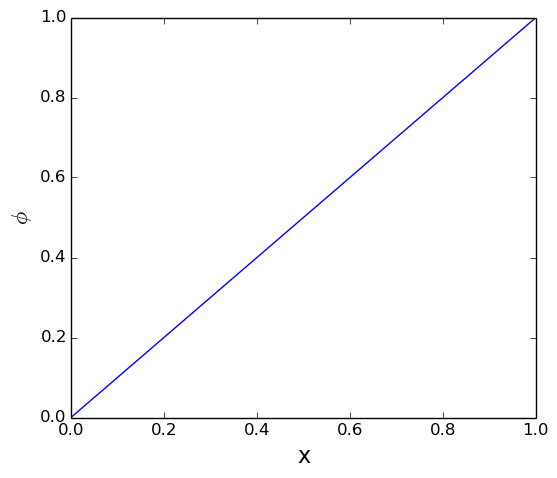

PyObject <matplotlib.text.Text object at 0x7fa9bb423310>

In [10]:
L= 1.0 # length of the domain
Nx= 20 # number of cells
m= createMesh1D(Nx, L) # create the domain and mesh
BC= createBC(m) # create the boundary condition
BC.left.a[:]= 0.0 # left side Neumann term equal to zero
BC.left.b[:]= 1.0 # left side Dirichlet term coefficient equal to one
BC.left.c[:]= 0.0 # left side Dirichlet term value equal to zero
BC.right.a[:]= 0.0
BC.right.b[:]= 1.0
BC.right.c[:]= 1.0
D_val= 1.0 # value of the transfer coefficient
D= createCellVariable(m, D_val) # assign D_val to all the cells
# harmonic average of the transfer coefficient on the cell faces:
D_face= harmonicMean(D)
(Mbc, RHSbc)= boundaryConditionTerm(BC)
Mdiff= diffusionTerm(D_face)
M= Mdiff+Mbc # matrix of coefficients
RHS= RHSbc # off course!
phi= solveLinearPDE(m, M, RHS) # solve the linear PDE
figure(figsize=(6.0,5.0)) # unit is [cm] for me
visualizeCells(phi) # visualize the results
# decorate the plot
xlabel("x", fontsize=16)
ylabel(L"\phi", fontsize=16)

## A colorful a bit playful case
The other night, my daughter wanted to see what I do with my computer. So I decided to solve an equation with fancy colorful results. So I created a diffusion process on a radial coordinate, Dirichlet boundary condition near the center of the circle (with alternationg zero-one values on the left boundary). I reduced the value of the diffusion coefficient in the direction of increasing $\theta$ to increase the contrast in the result. Let me recreate it here.

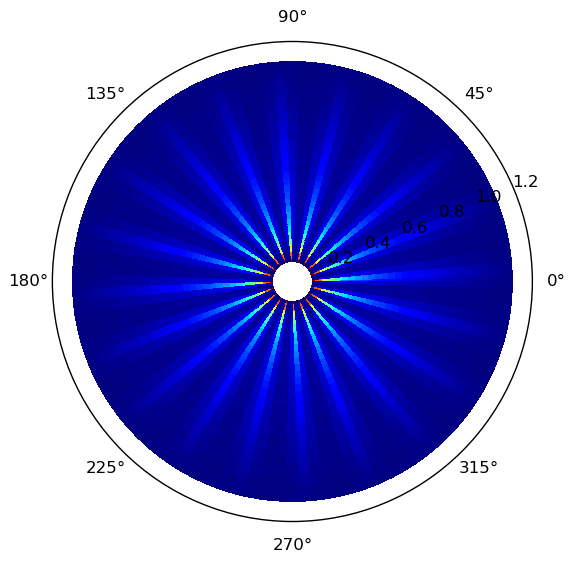

PyObject <matplotlib.collections.PolyCollection object at 0x7fa9b9744350>

In [39]:
L= 1.0 # length of the domain
Nx= 30 # number of cells
Ntheta= 5*20
m= createMeshRadial2D(Nx, Ntheta, L, 2π) # create the domain and mesh
m.cellcenters.x+=0.1
m.facecenters.x+=0.1
BC= createBC(m) # create the boundary condition
BC.left.a[:]= 0.0 # left side Neumann term equal to zero
BC.left.b[:]= 1.0 # left side Dirichlet term coefficient equal to one
BC.left.c[:]= 0.0 # left side Dirichlet term value equal to zero
BC.left.c[1:5:Ntheta]= 1.0
BC.right.a[:]= 0.0
BC.right.b[:]= 1.0
BC.right.c[:]= 0.0
BC.bottom.periodic=true # periodic boundary condition
D_val= 1.0 # value of the transfer coefficient
D= createCellVariable(m, D_val) # assign D_val to all the cells
# harmonic average of the transfer coefficient on the cell faces:
D_face= harmonicMean(D)
D_face.yvalue[:]=0.003*D_val
(Mbc, RHSbc)= boundaryConditionTerm(BC)
Mdiff= diffusionTerm(D_face)
M= -Mdiff+Mbc # matrix of coefficients
RHS= RHSbc # off course!
phi= solveLinearPDE(m, M, RHS) # solve the linear PDE
visualizeCells(phi) # visualize the results

## Not really bad!
That's it for now. I will come back with more real life examples.